In [61]:
#@title Install Packages

In [62]:
!pip install -q transformers
!pip install -q torchinfo
!pip install -q datasets
!pip install -q evaluate
!pip install -q nltk
!pip install -q contractions

In [63]:
!sudo apt-get update
! sudo apt-get install tree

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 261 kB in 2s (105 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pa

In [64]:
#@title Imports
import nltk
from nltk.tokenize import RegexpTokenizer

import evaluate
import transformers

import contractions

from torchinfo import summary
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn


In [65]:
# @title Mount Google Drive

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
dir_root = '/content/drive/MyDrive/266-final/'
# dir_data = '/content/drive/MyDrive/266-final/data/'
# dir_data = '/content/drive/MyDrive/266-final/data/se21-t1-comp-lex-master/'
dir_data = '/content/drive/MyDrive/266-final/data/266-comp-lex-master'
dir_models = '/content/drive/MyDrive/266-final/models/'
dir_results = '/content/drive/MyDrive/266-final/results/'

In [68]:
!tree /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/
├── fe-test-labels
├── fe-train
├── fe-trial-val
├── test-labels
│   ├── lcp_multi_test.tsv
│   └── lcp_single_test.tsv
├── train
│   ├── lcp_multi_train.tsv
│   └── lcp_single_train.tsv
└── trial
    ├── lcp_multi_trial.tsv
    └── lcp_single_trial.tsv

6 directories, 6 files


In [69]:
!ls -R /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/:
fe-test-labels	fe-train  fe-trial-val	test-labels  train  trial

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels:

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train:

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val:

/content/drive/MyDrive/266-final/data/266-comp-lex-master/test-labels:
lcp_multi_test.tsv  lcp_single_test.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/train:
lcp_multi_train.tsv  lcp_single_train.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/trial:
lcp_multi_trial.tsv  lcp_single_trial.tsv


In [70]:
#@title Import Data

In [71]:
# train_single_df = pd.read_csv(os.path.join(dir_data, "train", "lcp_single_train.tsv"), sep="\t")
# train_multi_df = pd.read_csv(os.path.join(dir_data, "train", "lcp_multi_train.tsv"), sep="\t")

# trail_val_single_df = pd.read_csv(os.path.join(dir_data, "trial", "lcp_single_trial.tsv"), sep="\t")
# trail_val_multi_df = pd.read_csv(os.path.join(dir_data, "trial", "lcp_multi_trial.tsv"), sep="\t")

# test_single_df = pd.read_csv(os.path.join(dir_data, "test-labels", "lcp_single_test.tsv"), sep="\t")
# test_multi_df = pd.read_csv(os.path.join(dir_data, "test-labels", "lcp_multi_test.tsv"), sep="\t")

In [72]:
# # Try to load the files containing unterminated strings
# try:
#     # Approach 1: Try with the C engine but with error handling
#     multi_test_df = pd.read_csv(
#         os.path.join(dir_data, "test", "lcp_multi_test.tsv"),
#         sep="\t",
#         on_bad_lines='skip'  # Skip bad lines
#     )
#     print("Loaded with skipping bad lines")
# except Exception as e:
#     print(f"First approach failed: {e}")
#     try:
#         # Approach 2: Try with the Python engine which might be more forgiving
#         multi_test_df = pd.read_csv(
#             os.path.join(dir_data, "test", "lcp_multi_test.tsv"),
#             sep="\t",
#             engine="python",
#             quoting=3  # QUOTE_NONE
#         )
#         print("Loaded with Python engine")


In [73]:
# Load train data into train_*_df
train_single_df = pd.read_csv(
    os.path.join(dir_data, "train", "lcp_single_train.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)
train_multi_df = pd.read_csv(
    os.path.join(dir_data, "train", "lcp_multi_train.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)

# Load trial data into trial_val_*_df
trial_val_single_df = pd.read_csv(
    os.path.join(dir_data, "trial", "lcp_single_trial.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)
trial_val_multi_df = pd.read_csv(
    os.path.join(dir_data, "trial", "lcp_multi_trial.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)

# Load test data (with labels) into test_*_df
test_single_df = pd.read_csv(
    os.path.join(dir_data, "test-labels", "lcp_single_test.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)
test_multi_df = pd.read_csv(
    os.path.join(dir_data, "test-labels", "lcp_multi_test.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)

print("Data successfully loaded into train, trial-val, and test variables")

Data successfully loaded into train, trial-val, and test variables


In [74]:
#@title EDA

In [75]:
def print_dataframe_summary(df_name, df):
    # Print section header
    print(f"========== {df_name} ==========")

    # Shape and Columns
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}\n")

    # Data Types
    print("Data Types:")
    print(df.dtypes)
    print()

    # Missing Values
    print("Missing Values (by column):")
    print(df.isna().sum())
    print()

    # 'complexity' column stats
    desc = df['complexity'].describe()  # count, mean, std, min, 25%, 50%, 75%, max
    print("'complexity' Column Stats (incl. quartiles and median):")
    print(desc)

    # Calculate frequency counts for each quartile range
    q1 = desc['25%']
    q2 = desc['50%']  # This is the median
    q3 = desc['75%']
    q_max = desc['max']

    # Note: We'll define the ranges as:
    #   <= Q1
    #   > Q1 and <= Q2
    #   > Q2 and <= Q3
    #   > Q3

    freq_q1 = np.sum(df['complexity'] <= q1)
    freq_q2 = np.sum((df['complexity'] > q1) & (df['complexity'] <= q2))
    freq_q3 = np.sum((df['complexity'] > q2) & (df['complexity'] <= q3))
    freq_q4 = np.sum(df['complexity'] > q3)

    print()
    print("Quartile Frequency Counts (tab-separated next to each quartile):")
    print(f"25%: {q1}\tCount (<= Q1): {freq_q1}")
    print(f"50% (Median): {q2}\tCount (Q1 < x <= Q2): {freq_q2}")
    print(f"75%: {q3}\tCount (Q2 < x <= Q3): {freq_q3}")
    print(f"100% (Max): {q_max}\tCount (Q3 < x <= Max): {freq_q4}")

    print("======================================\n")

# Now we call this for each of our dataframes
print_dataframe_summary("train_single_df", train_single_df)
print_dataframe_summary("train_multi_df", train_multi_df)
print_dataframe_summary("trial_val_single_df", trial_val_single_df)
print_dataframe_summary("trial_val_multi_df", trial_val_multi_df)
print_dataframe_summary("test_single_df", test_single_df)
print_dataframe_summary("test_multi_df", test_multi_df)


========== train_single_df ==========
Shape: (7662, 5)
Columns: ['id', 'corpus', 'sentence', 'token', 'complexity']

Data Types:
id             object
corpus         object
sentence       object
token          object
complexity    float64
dtype: object

Missing Values (by column):
id            0
corpus        0
sentence      0
token         7
complexity    0
dtype: int64

'complexity' Column Stats (incl. quartiles and median):
count    7662.000000
mean        0.302288
std         0.132977
min         0.000000
25%         0.211538
50%         0.279412
75%         0.375000
max         0.861111
Name: complexity, dtype: float64

Quartile Frequency Counts (tab-separated next to each quartile):
25%: 0.2115384615384615	Count (<= Q1): 1928
50% (Median): 0.2794117647058823	Count (Q1 < x <= Q2): 1937
75%: 0.375	Count (Q2 < x <= Q3): 1984
100% (Max): 0.8611111111111112	Count (Q3 < x <= Max): 1813

========== train_multi_df ==========
Shape: (1517, 5)
Columns: ['id', 'corpus', 'sentence', 'token'

In [76]:
print(train_single_df.head())

                               id corpus                                           sentence     token  complexity
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible  Behold, there came up out of the river seven c...     river    0.000000
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible  I am a fellow bondservant with you and with yo...  brothers    0.000000
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3  bible  The man, the lord of the land, said to us, 'By...  brothers    0.050000
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738  bible  Shimei had sixteen sons and six daughters; but...  brothers    0.150000
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2  bible               "He has put my brothers far from me.  brothers    0.263889


In [77]:
print(train_multi_df.head())

                               id corpus                                           sentence            token  complexity
0  3S37Y8CWI80N8KVM53U4E6JKCDC4WE  bible  but the seventh day is a Sabbath to Yahweh you...      seventh day    0.027778
1  3WGCNLZJKF877FYC1Q6COKNWTDWD11  bible  But let each man test his own work, and then h...         own work    0.050000
2  3UOMW19E6D6WQ5TH2HDD74IVKTP5CB  bible  To him who by understanding made the heavens; ...  loving kindness    0.050000
3  36JW4WBR06KF9AXMUL4N476OMF8FHD  bible  Remember to me, my God, this also, and spare m...  loving kindness    0.050000
4  3HRWUH63QU2FH9Q8R7MRNFC7JX2N5A  bible  Because your loving kindness is better than li...  loving kindness    0.075000


In [78]:
#@title Data Engineering

In [79]:
# Assuming you have already loaded the DataFrames:
# train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df

def print_distinct_values(df, column_name):
    """Prints the distinct values of a specified column in a DataFrame."""
    distinct_values = df[column_name].unique()
    print(f"Distinct values in '{column_name}' column:")
    for value in distinct_values:
        print(value)
    print("-" * 30)  # Separator

# Print distinct values for each DataFrame
print_distinct_values(train_single_df, "corpus")
print_distinct_values(train_multi_df, "corpus")
print_distinct_values(trial_val_single_df, "subcorpus")
print_distinct_values(trial_val_multi_df, "subcorpus")
print_distinct_values(test_single_df, "corpus")
print_distinct_values(test_multi_df, "corpus")

Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'subcorpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'subcorpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------


## standardize column headers: convert trial_val header from 'subcorpus' to 'corpus'

In [80]:
# Rename the 'subcorpus' column to 'corpus'
trial_val_single_df = trial_val_single_df.rename(columns={'subcorpus': 'corpus'})
trial_val_multi_df = trial_val_multi_df.rename(columns={'subcorpus': 'corpus'})

# Verify the change (optional)
print(trial_val_single_df.columns)
print(trial_val_multi_df.columns)

Index(['id', 'corpus', 'sentence', 'token', 'complexity'], dtype='object')
Index(['id', 'corpus', 'sentence', 'token', 'complexity'], dtype='object')


In [81]:
dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]

# Get the headers (column names) of the first DataFrame as a reference
reference_headers = list(dataframes[0].columns)

# Loop through the remaining DataFrames and compare headers
all_headers_match = True
for df in dataframes[1:]:
    if list(df.columns) != reference_headers:
        all_headers_match = False
        print(f"Headers do not match for DataFrame: {df.head(0)}")  # Print which DataFrame has different headers
        break  # Exit the loop if a mismatch is found

# Print the result
if all_headers_match:
    print("All DataFrames have matching headers.")
else:
    print("Headers do not match for all DataFrames.")

All DataFrames have matching headers.


## Interrogate Span Length by Corpus Value by Data Split

In [82]:
# Analyzing sentence spans by complexity quartile and corpus

tokenizer = RegexpTokenizer(r'\w+') # setup tokenizer

def analyze_sentence_spans_by_corpus_and_quartile(dfs_dict):
    """
    Analyze sentence spans (length metrics) grouped by corpus and complexity quartile
    for multiple dataframes.
    """
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name}...")

        # Calculate complexity quartiles for this dataframe
        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        # Define quartile ranges for labeling
        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        # Add quartile column
        df = df.copy()
        df['quartile'] = df['complexity'].apply(get_quartile)

        # Compute sentence metrics using RegexpTokenizer instead of word_tokenize
        def compute_span_metrics(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            # Use our tokenizer that doesn't require punkt_tab
            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(word) for word in words]) if word_count > 0 else 0
            return pd.Series({'word_count': word_count, 'char_count': char_count, 'avg_word_len': avg_word_len})

        # Apply the function to each sentence
        span_metrics = df['sentence'].apply(compute_span_metrics)
        df = pd.concat([df, span_metrics], axis=1)

        # Get corpus column name (could be 'corpus' or 'subcorpus')
        corpus_col = 'corpus' if 'corpus' in df.columns else 'subcorpus'

        # Group by corpus and quartile
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                # Calculate statistics
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    # Convert to DataFrame and sort
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])

    return results_df

# Create dictionary of dataframes
dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

# Run analysis
span_analysis = analyze_sentence_spans_by_corpus_and_quartile(dfs)

# Display results
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(span_analysis)

# Save the analysis results
results_path = os.path.join(dir_results, 'sentence_span_analysis.csv')
span_analysis.to_csv(results_path, index=False)
print(f"Analysis saved to: {results_path}")

Processing train_single_df...
Processing train_multi_df...
Processing trial_val_single_df...
Processing trial_val_multi_df...
Processing test_single_df...
Processing test_multi_df...


,Dataframe,Corpus,Quartile,Complexity Range,Count,Avg Words,Median Words,Min Words,Max Words,Std Words,Avg Chars,Avg Word Len
60,test_multi_df,bible,Q1,0.025-0.317,26,23.076923,22.0,4.0,48.0,11.831900,118.653846,4.128898
61,test_multi_df,bible,Q2,0.325-0.417,11,20.545455,17.0,7.0,47.0,12.917923,109.545455,4.209752
62,test_multi_df,bible,Q3,0.432-0.528,18,21.111111,21.5,4.0,43.0,10.889222,112.777778,4.474206
63,test_multi_df,bible,Q4,0.542-0.694,11,22.363636,20.0,7.0,51.0,11.935432,126.181818,4.605062
64,test_multi_df,biomed,Q1,0.000-0.312,11,29.818182,29.0,17.0,47.0,8.388304,195.727273,5.491145
65,test_multi_df,biomed,Q2,0.324-0.417,11,27.090909,24.0,9.0,47.0,11.449494,171.818182,5.436237
66,test_multi_df,biomed,Q3,0.456-0.528,10,26.900000,26.5,10.0,49.0,10.712921,177.500000,5.497409
67,test_multi_df,biomed,Q4,0.562-0.800,21,32.285714,34.0,14.0,56.0,13.598319,209.285714,5.460101
68,test_multi_df,europarl,Q1,0.214-0.303,10,24.700000,24.5,7.0,56.0,14.189589,146.900000,5.049688
69,test_multi_df,europarl,Q2,0.321-0.429,24,27.833333,27.0,9.0,73.0,15.352855,172.291667,5.269610


Analysis saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis.csv


<ipython-input-83-00a8ad5642c1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(span_analysis, x='Avg Words', y='Dataframe', inner='stick', palette='Dark2')


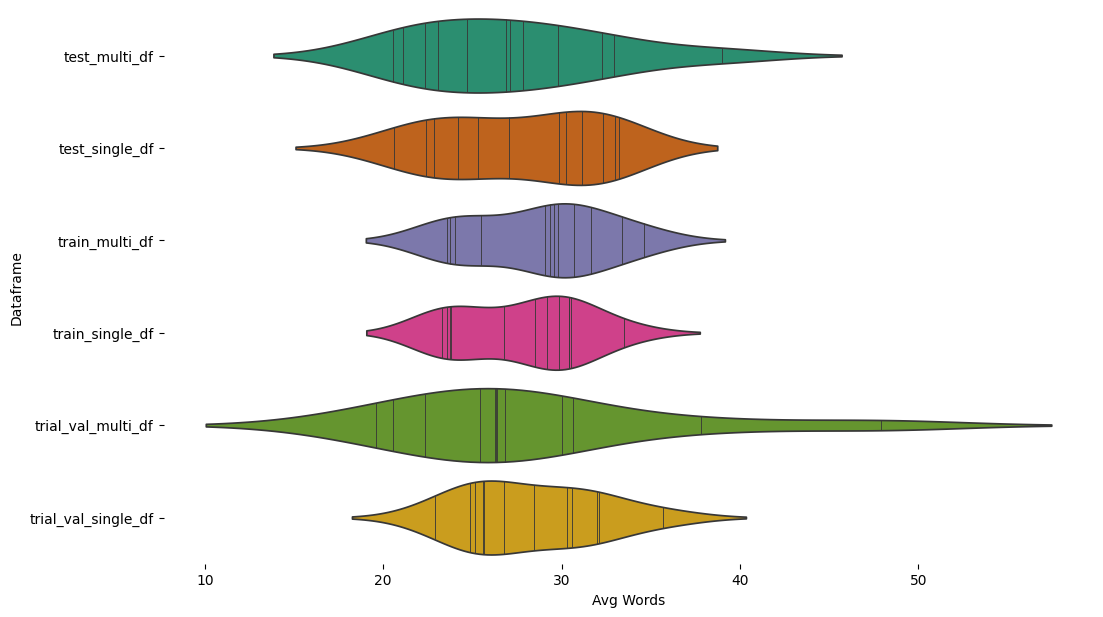

In [83]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(span_analysis['Dataframe'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(span_analysis, x='Avg Words', y='Dataframe', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

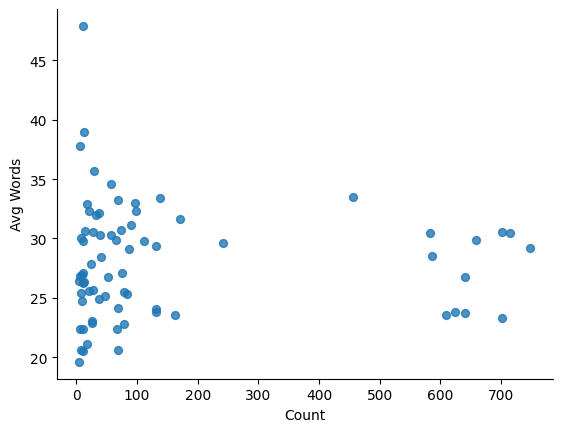

In [84]:
from matplotlib import pyplot as plt
span_analysis.plot(kind='scatter', x='Count', y='Avg Words', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-85-01bf0c89d620>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(span_analysis, x='Max Words', y='Dataframe', inner='stick', palette='Dark2')


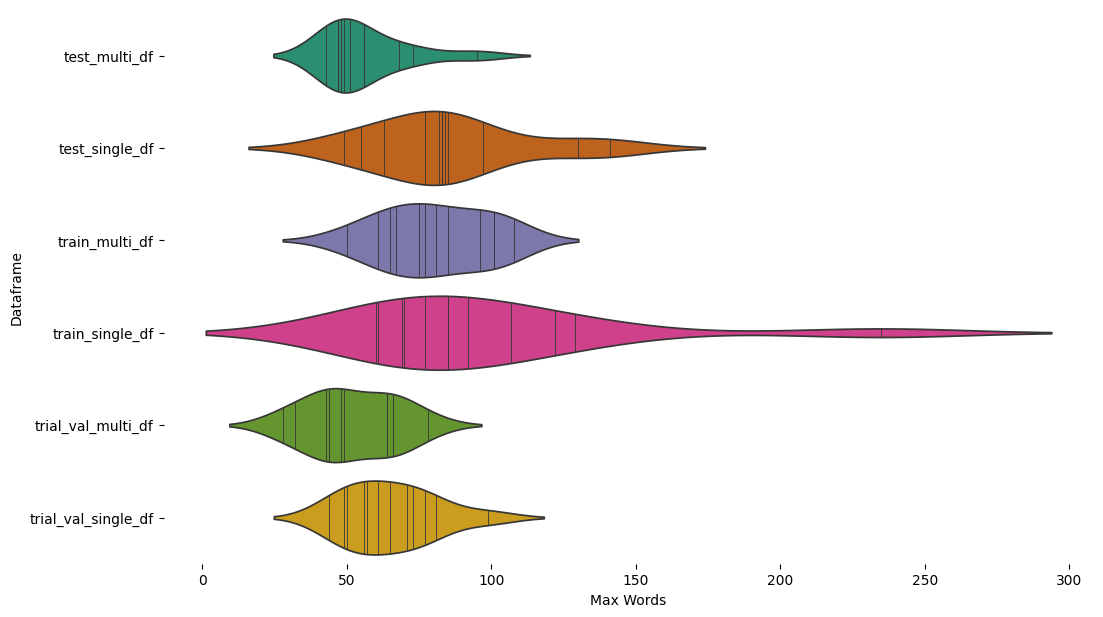

In [85]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(span_analysis['Dataframe'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(span_analysis, x='Max Words', y='Dataframe', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

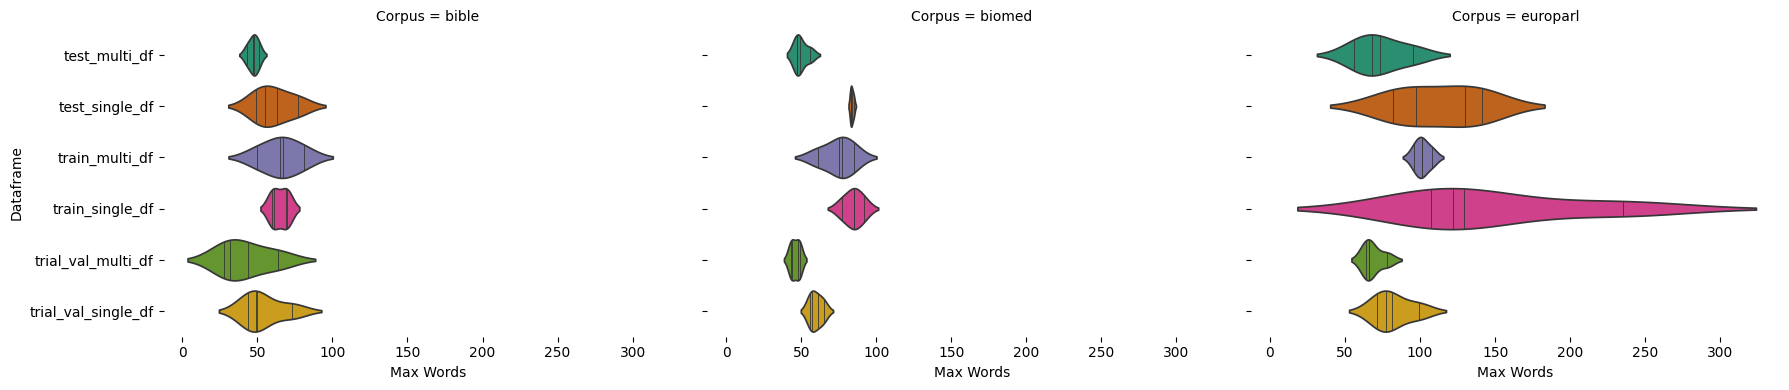

In [86]:

# Create a FacetGrid
g = sns.FacetGrid(span_analysis, col="Corpus", col_wrap=3, height=4, aspect=1.5)  # Adjust col_wrap and height as needed

# Map the violinplot to the FacetGrid
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')

# Remove spines for cleaner look
g.despine(top=True, right=True, bottom=True, left=True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()